# Time Series - Kaggle

'0.23.4'

In [1]:
from random import randint, shuffle
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("."))

['.git', '.ipynb_checkpoints', 'LSTM.ipynb', 'kaggle_em.ipynb', 'test_data.zip', 'test_data', 'timeSeries_LV.ipynb', 'train_data.zip', 'train_data', 'timeSeries_LV.py', 'result_gs.txt']


## Chargement des données

In [2]:
df_train = pd.read_csv('train_data/train_data.csv', sep=',')
df_test = pd.read_csv('test_data/test_data.csv', sep=',')

## Définition des moteurs train et tests

In [3]:
list_engine_no = list(df_train['engine_no'].drop_duplicates())
ratio = .0
shuffle(list_engine_no)

In [4]:
engine_no_test = list_engine_no[:int(len(list_engine_no) * ratio)]
engine_no_train = [x for x in list_engine_no if x not in engine_no_test]

## Cleaning: colonnes nan / constantes / metadata

In [5]:
nan_column = df_train.columns[df_train.isna().any()].tolist()
const_columns = [c for c in df_train.columns if len(df_train[c].drop_duplicates()) <= 2]
print('Columns with all nan: \n' + str(nan_column) + '\n')
print('Columns with all const values: \n' + str(const_columns) + '\n')

Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']

Columns with all const values: 
['op_setting_3', 'sensor_16', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']



In [6]:
metadata_columns = ['engine_no', 'time_in_cycles']
sensor_columns = [col for col in df_train.columns
                  if col.startswith("sensor_") and
                 col not in metadata_columns + nan_column + const_columns]

## Transformation des données
### Ajout de l'historique des capteurs

In [7]:
# feature adding
def add_old_info(group, sensor_columns, _range):
    for i in _range:
        tmp_new_cols = [col+"_t-"+str(i) for col in sensor_columns]
        group[tmp_new_cols] = group[sensor_columns].shift(i)
    return group

previous_states=list(range(1,5))
df_train = df_train.groupby("engine_no").apply(add_old_info, sensor_columns, previous_states)
print(df_train.shape)
df_train.head()

(160359, 109)


,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_10_t-4,sensor_11_t-4,sensor_12_t-4,sensor_13_t-4,sensor_14_t-4,sensor_15_t-4,sensor_17_t-4,sensor_18_t-4,sensor_20_t-4,sensor_21_t-4
0,0,1,25.0074,0.6200,60.0,462.54,536.84,1256.52,1043.97,7.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,35.0072,0.8413,100.0,449.44,555.44,1364.42,1128.75,5.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3,25.0053,0.6215,60.0,462.54,536.42,1265.94,1047.23,7.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,4,42.0045,0.8407,100.0,445.00,549.41,1355.52,1115.81,3.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,5,35.0046,0.8400,100.0,449.44,555.21,1361.04,1123.63,5.48,...,0.94,36.7,164.75,2028.38,7875.47,10.885,306.0,1915.0,14.35,8.4712


In [8]:
selected_features = [x for x in df_train.columns 
                     if x not in metadata_columns + nan_column + const_columns and
                     x.startswith("sensor_")]

In [9]:
df_train.dropna(subset=selected_features, inplace=True)
df_train.shape

(157523, 109)

### Normalisation

In [10]:
normalize=False

In [11]:
if normalize:
    from sklearn.preprocessing import MinMaxScaler
    _values = df_train[selected_features].values
    _scaler = MinMaxScaler()
    scaled_values = _scaler.fit_transform(_values)
    df_train[selected_features] = pd.DataFrame(scaled_values)
    df_train.head()


## Split train - test

In [12]:
df_train_train = df_train[df_train['engine_no'].isin(engine_no_train)]
# df_eval = df_train[df_train['engine_no'].isin(engine_no_test)]

X_train_train, y_train_train = df_train_train[selected_features], df_train_train['RUL'] 
y_train_train = np.where(y_train_train >= 150, 150, y_train_train)

sample_weight = np.where(y_train_train >= 120, 0.5, 
                np.where(y_train_train <=80, .5, 2.))


# X_eval, y_eval = df_eval[selected_features], df_eval['RUL']
# y_eval = np.where(y_eval >= 150, 150, y_eval)

X_train_all, y_train_all = df_train[selected_features], df_train['RUL']

## Modelisation

In [1]:
import xgboost
from sklearn.metrics import f1_score, precision_score, recall_score


list_learning_rate = [0.05, 0.02, 0.01, 0.005]
list_tree = [100,300,500]
list_max_depth = [10,12,14,16]
list_min_child_weight= [1, 5, 10]
list_gamma = [0.5, 1, 2, 5]
list_subsample = [0.8, 1.0]
list_colsample_bytree = [0.6, 0.8, 1.0]

score = 0

for tree in list_tree:
    for max_depth in list_max_depth:
        for min_child_weight in list_min_child_weight:
            for gamma in list_gamma:
                for subsample in list_subsample:
                    for colsample_bytree in list_colsample_bytree:
                        model = xgboost.XGBRegressor(max_depth=max_depth, learning_rate=0.02, n_estimators=tree, silent=True,
                                                     min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, nthread=2, reg_lambda=0, reg_alpha=1)
                        model.fit(X_train_train, y_train_train)
                        
                        y_pred = np.where(model.predict(X_eval) >= 100, 0, 1)
                        y_eval_rea = np.where(y_eval >= 100, 0, 1)
                        
                        score_ = f1_score(y_eval_rea, y_pred)
                        print(score_)
                        
                        if score_ > score:
                            tmp_tree = tree
                            tmp_max_depth = max_depth
                            tmp_min_child_weight = min_child_weight
                            tmp_gamma = gamma
                            tmp_subsample = subsample
                            tmp_colsample_bytree = colsample_bytree
                            score = score_ 

print("results Grid Search : ")
print(tmp_tree)
print(tmp_max_depth)
print(tmp_min_child_weight)
print(tmp_gamma)
print(tmp_subsample)
print(tmp_colsample_bytree)
print("score :")
print(score)
                            

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'X_train_train' is not defined

In [13]:
import xgboost
from sklearn.metrics import f1_score, precision_score, recall_score

model = xgboost.XGBRegressor(max_depth=12, learning_rate=0.01, n_estimators=300, silent=True,
                                                     min_child_weight=5, gamma=2, subsample=1, colsample_bytree=0.8, nthread=2,
                                                     reg_lambda=0, reg_alpha=1)

model.fit(X_train_train, y_train_train, sample_weight=sample_weight)

y_pred = np.where(model.predict(X_eval) >= 100, 0, 1)
y_eval_rea = np.where(y_eval >= 100, 0, 1)

score_ = f1_score(y_eval_rea, y_pred)
print(score_)


NameError: name 'X_eval' is not defined

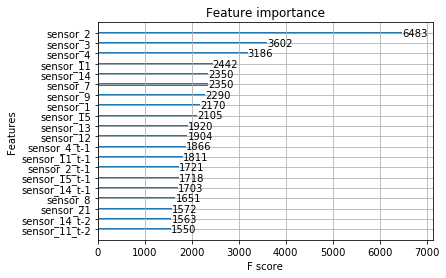

In [15]:
# xgboost.plot_importance(model, max_num_features = 20)
# plt.show()

In [14]:
y_pred = np.where(model.predict(X_eval) >= 100, 0, 1)
y_eval_rea = np.where(y_eval >= 100, 0, 1)
from sklearn.metrics import f1_score, precision_score, recall_score
print(f1_score(y_eval_rea, y_pred))
print(precision_score(y_eval_rea, y_pred))
print(recall_score(y_eval_rea, y_pred))


NameError: name 'X_eval' is not defined

##  Prédictions

In [15]:
df_test = df_test.groupby("engine_no").apply(add_old_info, sensor_columns, previous_states)
df_test.dropna(subset=selected_features, inplace=True)
X_test = df_test[selected_features]

In [61]:
def predict_and_format(df, features, wdw_size, threshold):
    df["pred_values"] = model.predict(features)
    df = df.sort_values(['engine_no', 'time_in_cycles'])
    df["result"] = np.where(df['pred_values'] > 100, 0, 1)
    df["avg_result"] = df["result"].rolling(wdw_size).mean()
    df["result"] = np.where(df["avg_result"]>=threshold, 1, df["result"])
    df_res = df.groupby('engine_no').last().reset_index()[['engine_no', 'pred_values','result']]
    return df_res, df

In [16]:
wdw_size = 1
# threshold = 0.3
# df_result, df_tmp = predict_and_format(df_test, X_test, wdw_size, threshold)
# df_result[["engine_no","result"]].to_csv("submit4.csv", sep=",", index=False)

In [17]:
df_test['pred_values'] =  model.predict(X_test)
df_test = df_test.sort_values(['engine_no', 'time_in_cycles'])

df_result_other = df_test[['engine_no', 'time_in_cycles', 'pred_values']]
df_result_other = df_result_other.groupby("engine_no").apply(add_old_info, ['pred_values'], range(1,wdw_size))

In [18]:
df_result_other['tmp_mean'] = df_result_other['pred_values'] 

for shift in range(1,wdw_size):
    df_result_other['tmp_mean'] += df_result_other['pred_values_t-' + str(shift)] - shift
    
df_result_other['result_reg'] = df_result_other['tmp_mean']/(wdw_size)
df_result_other["result"] = np.where(df_result_other['result_reg'] >= 100, 0, 1)
df_res_other = df_result_other.groupby('engine_no').last().reset_index()[['engine_no','result']]

In [19]:
df_res_other[["engine_no","result"]].to_csv("submit_other_rolling.csv", sep=",", index=False)

In [20]:
df_res_other

,engine_no,result
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
5,5,0
6,6,0
7,7,1
8,8,1
9,9,0
